In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

from collections import Counter

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

from sklearn.decomposition import PCA

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe

import sqlite3

c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import split_images
reload(split_images)
from split_images import split_geometry, haversine, calc_segment_count

In [3]:
from analysis_image import AnalysisImage
from keras.preprocessing import image

In [4]:
ee.Authenticate()
ee.Initialize()

In [5]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
# FEATURES = ['B2', 'B3', 'B4']

In [6]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [29]:
tegu_200_eloisa = None

In [30]:
# Load eloisa_databases/tegu_200x200_flatten.pkl
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'rb') as f:
    tegu_200_eloisa = pickle.load(f)

tegu_200_eloisa._database = sqlite3.connect(tegu_200_eloisa.db_path)

In [8]:
from tensorflow.keras.applications import ResNet152V2 as resnet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_p

In [9]:
years = [2018, 2019, 2020, 2021, 2022, 2023]

In [36]:
tegu_200_eloisa.extract_features_multiyear(years=years, model=resnet, preprocess_input=resnet_p)

650/650 ━━━━━━━━━━━━━━━━━━━━ 4120s 6s/step


In [37]:
tegu_200_eloisa.update_database()

In [ ]:
tegu_200_eloisa.vacuum_db()

In [11]:
tegu_200_eloisa.scale_features(years=years, model=resnet)

In [26]:
tegu_200_eloisa.pca_features(years=years, model=resnet, n_components=1251, plot_variance=True, chunk_size=2000)

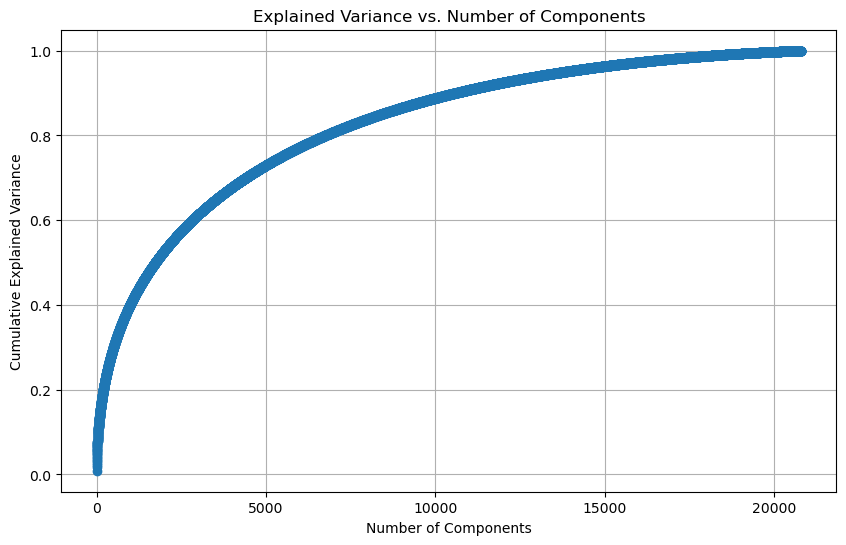

Number of components to retain 95.0% variance: 13786


In [12]:
tegu_200_eloisa.pca_features(years=years, model=resnet, variance_min=0.95, plot_variance=True)

In [88]:
tegu_200_eloisa._database = ""
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'wb') as f:
    pickle.dump(tegu_200_eloisa, f)
tegu_200_eloisa._database = sqlite3.connect(tegu_200_eloisa.db_path)

In [10]:
tegu_200_eloisa[2018]["ResNet152V2_cluster"]

array([ 4, 30, 10, ...,  8,  7, 48])

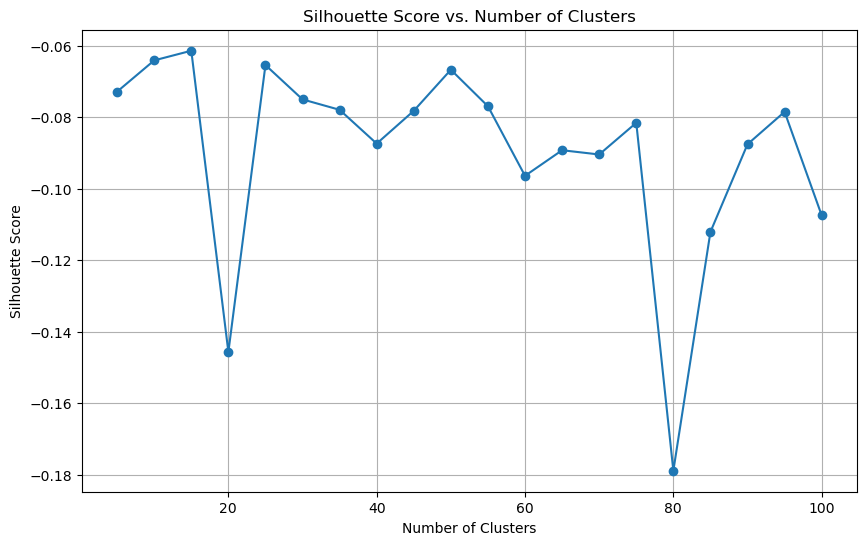

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(5, 100 + 1, 5), sil, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

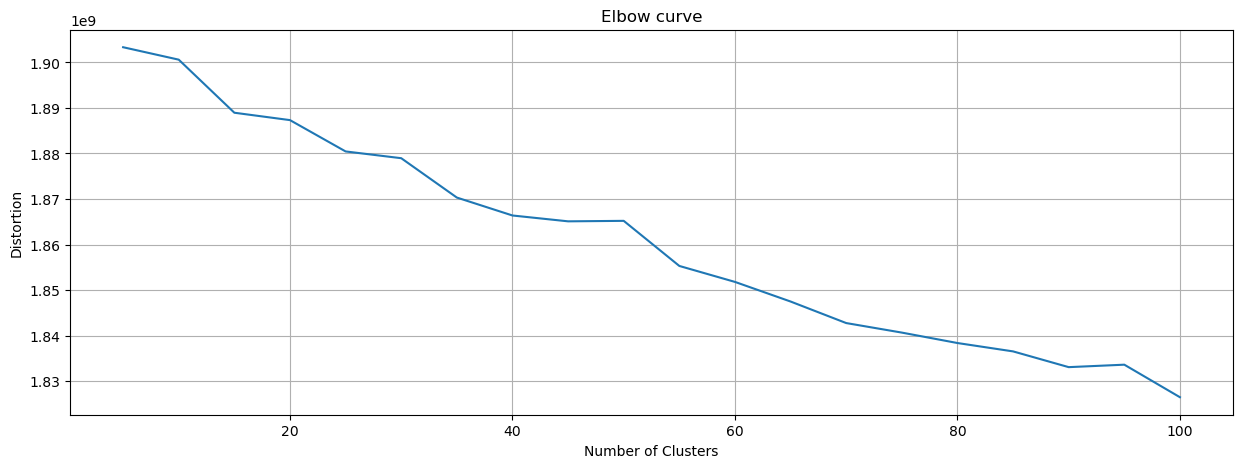

In [14]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(5, 100+1, 5), distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [11]:
sil, distortions = tegu_200_eloisa.calc_silhouette_score(years=years, model=resnet, show_plot=False, kmin=5, kmax=100, increment=5)

Calculating silhouette scores:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Calculating silhouette scores:   5%|▌         | 1/20 [09:22<2:58:08, 562.54s/it]c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Calculating silhouette scores:  10%|█         | 2/20 [19:36<2:57:47, 592.64s/it]c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

In [87]:
# Print the highest score found in the list sil
print(max(sil[1:]))

# Print the index of the highest score found in the list sil
print(sil.index(max(sil[1:])))

0.007939352
1


c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412:

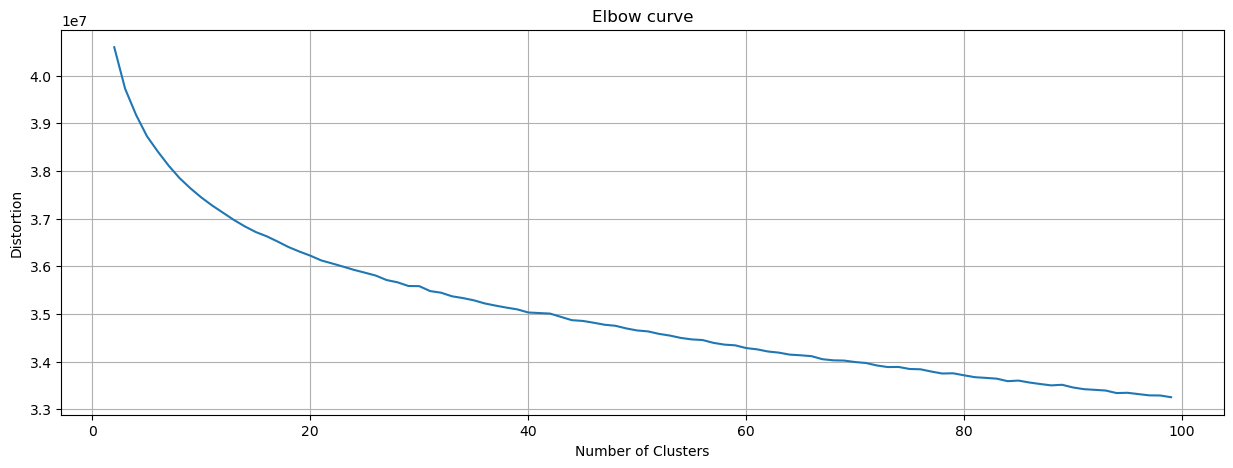

In [42]:
tegu_200_eloisa.plot_elbow_curve(years=years, model=resnet)

# CUTOFF

In [20]:
clusterer = tegu_200_eloisa.calc_clusters(years=years, model=resnet, algorithm="optics")

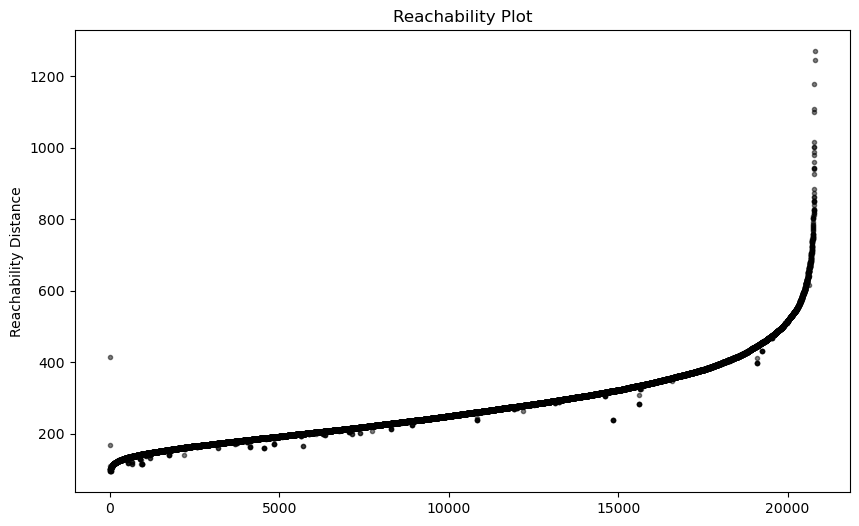

In [25]:
# Reachability plot
plt.figure(figsize=(10, 6))
space = np.arange(20795)
reachability = clusterer.reachability_[clusterer.ordering_]
plt.plot(space, reachability, 'k.', alpha=0.5)
plt.ylabel('Reachability Distance')
plt.title('Reachability Plot')
plt.show()

In [11]:
kmeans = tegu_200_eloisa.calc_kmeans_clusters(years=years, model=resnet, n_clusters=50)

c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [30]:
# save kmeans to pickle file
with open('kmeans_50.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

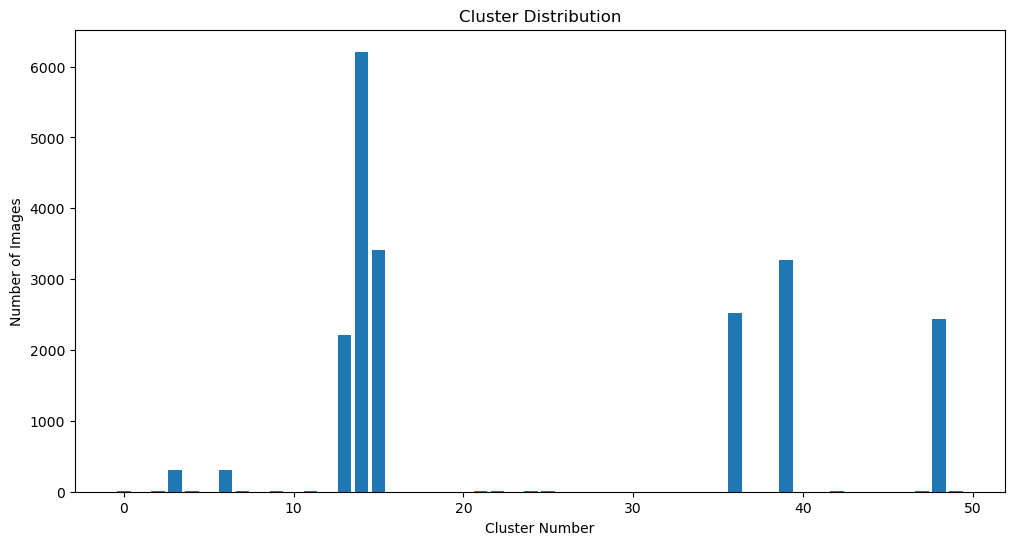

In [12]:
tegu_200_eloisa.plot_cluster_counts(years=years, model=resnet)

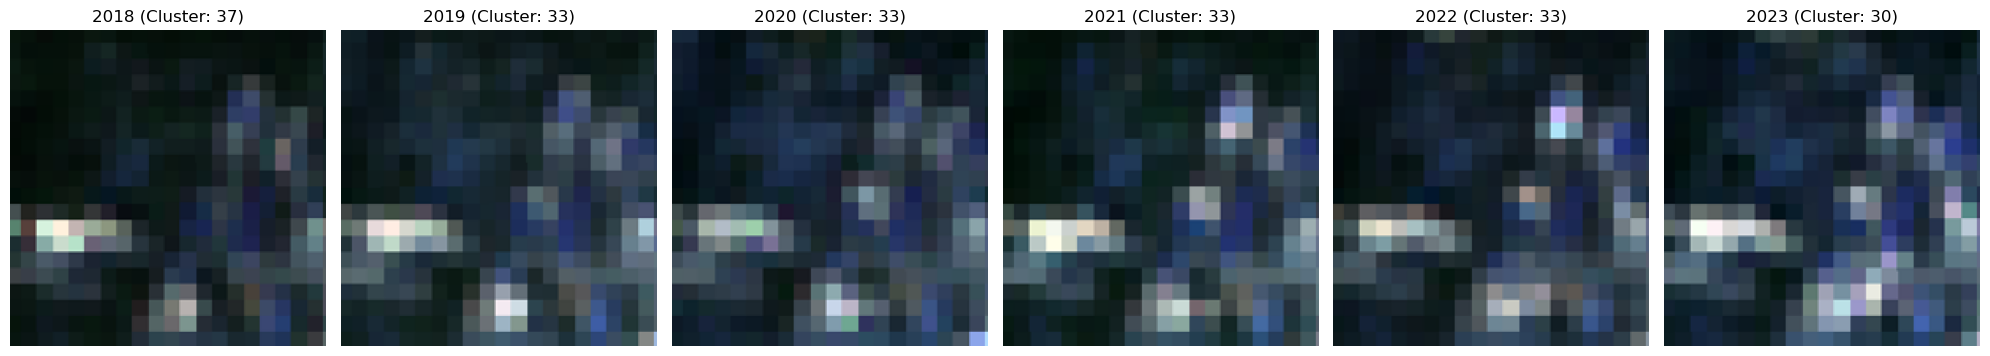

In [87]:
tegu_200_eloisa.show_clip_by_year(years=years, index=97, model=resnet)

In [30]:
# tegu_200_eloisa.update_database()

In [31]:
# tegu_200_eloisa.close_db()

# Delete database using os.remove() method
# os.remove(tegu_600_eloisa.db_path)

In [149]:
# Save the Eloisa object to a pickle file
# tegu_200_eloisa._database = ""      
# with open('eloisa_databases/tegu_200x200_flatten.pkl', 'wb') as f:
#     pickle.dump(tegu_200_eloisa, f)

In [10]:
# Load kmeans from pickle file
with open('kmeans_50.pkl', 'rb') as f:
    kmeans = pickle.load(f)

## Order K-means Clusters

In [11]:
cluster_centroids = kmeans.cluster_centers_

# Step 2: Apply PCA to the cluster centroids
pca = PCA(n_components=1)
centroids_pca = pca.fit_transform(cluster_centroids)

# Step 3: Project each centroid onto the top principal component
# (This is effectively done by the PCA transformation above)

# Step 4: Sort the clusters based on the projected values
sorted_indices = np.argsort(centroids_pca.flatten())

In [60]:
# Instead of getting only the sorted indices, create a dictionary with the cluster number as the key
# and the centroid pca value as the value
sorted_clusters = {i: float(centroids_pca[i]) for i in sorted_indices}

C:\Users\Juanes\AppData\Local\Temp\ipykernel_11924\1929636035.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sorted_clusters = {i: float(centroids_pca[i]) for i in sorted_indices}


In [14]:
# Create a mapping to assign the cluster number to the sorted index
cluster_mapping = {cluster: i for i, cluster in enumerate(sorted_clusters)}

In [33]:
# For each year, apply the cluster mapping to the cluster labels
for year in years:
    u,inv = np.unique(tegu_200_eloisa[year]["ResNet152V2_cluster"], return_inverse = True)
    tegu_200_eloisa[year]["ResNet152V2_cluster"] = np.array([cluster_mapping[x] for x in u])[inv].reshape(tegu_200_eloisa[year]["ResNet152V2_cluster"].shape)

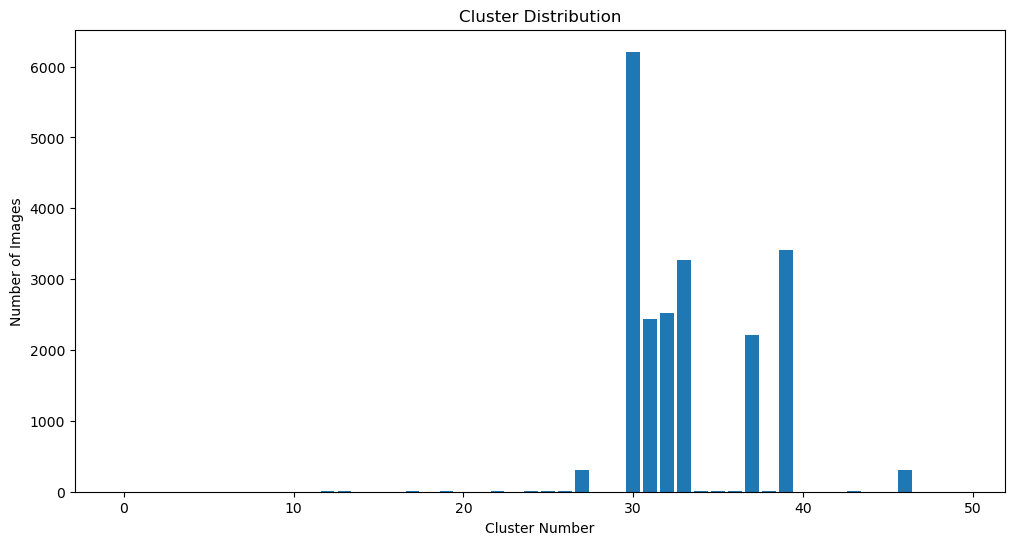

In [94]:
tegu_200_eloisa.plot_cluster_counts(years=years, model=resnet)

In [104]:
# Map sorted_clusters_shortened keys with cluster_mapping
sorted_clusters_mapped = {cluster_mapping[k]: v for k, v in sorted_clusters.items()}

In [102]:
cluster_counts = tegu_200_eloisa.get_cluster_counts(years=years, model=resnet)

In [118]:
# For each key in sorted_clusters, if the key is in cluster_counts and the value is less than 1, remove the key from sorted_clusters
sorted_clusters_shortened = {k: v for k, v in sorted_clusters_mapped.items() if k in cluster_counts and cluster_counts[k] > 400}

In [119]:
sorted_clusters_shortened

{30: -19.30872917175293,
 31: -19.168943405151367,
 32: -18.919118881225586,
 33: -18.83035659790039,
 37: -18.408174514770508,
 39: -18.01519012451172}

## Cluster Metric Testing

In [90]:
import cluster_tester
reload(cluster_tester)
from cluster_tester import ClusterTester

In [41]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2023, feature_bands=FEATURES)

img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 200, 200)

subgeometries = split_geometry(tegucigalpa_image.geometry_sd, x_num_parts=x_num_parts, y_num_parts=y_num_parts)

In [42]:
# For every item in subgeometries, get the centroid
centroids = [subgeom.centroid for subgeom in subgeometries]

# Convert to dataframe
centroids = gpd.GeoDataFrame(geometry=centroids, crs='EPSG:4326')

In [43]:
precario_path = os.path.join("data", "tegucigalpa_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [44]:
# Get cluster location multipolygons
cluster_location_info = tegu_200_eloisa.get_cluster_location_info(year=2023, model=resnet, subgeometries=subgeometries, dissolve_by_cluster=True)

In [133]:
tegu_cluster_tester.colormap

{30: '#0d0887',
 31: '#44039e',
 32: '#910ea3',
 33: '#a72197',
 37: '#f1834c',
 39: '#f0f921'}

In [132]:
tegu_cluster_tester = ClusterTester(cluster_location_info=cluster_location_info, 
                                    analysis_image=tegucigalpa_image, 
                                    validation_data=precario_gdf, 
                                    cluster_order=sorted_clusters_shortened, 
                                    num_clusters=50,
                                    palette='plasma')

tegu_cluster_tester.plot_clusters()

In [76]:
points = tegu_cluster_tester.create_sampling_points(points=centroids)

In [77]:
cluster_metrics = tegu_cluster_tester.calc_sampling_metrics()

c:\Users\Juanes\Desktop\UCL\TemporalClusterNet\src\cluster_tester.py:182: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  precision_recall_df = pd.concat([precision_recall_df, pd.DataFrame({"cluster": cluster, "precision": precision, "recall": recall, "F1": f1}, index=[0])], ignore_index=True)
c:\Users\Juanes\Desktop\UCL\TemporalClusterNet\src\cluster_tester.py:180: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
c:\Users\Juanes\Desktop\UCL\TemporalClusterNet\src\cluster_tester.py:180: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
c:\Users\Juanes\Desktop\UCL\TemporalClusterNet\src\cluster_tester.py:180: Runtime

In [78]:
cluster_metrics

,cluster,precision,recall,F1
0,39,0.052734,0.077586,0.062791
1,37,0.061972,0.063218,0.062589
2,30,0.169526,0.482759,0.250934
3,32,0.053933,0.068966,0.060530
4,31,0.093897,0.114943,0.103359
5,46,0.037736,0.005747,0.009975
6,27,0.050000,0.005747,0.010309
7,33,0.096563,0.169540,0.123045
8,34,0.000000,0.000000,NaN
9,17,0.000000,0.000000,NaN


In [79]:
grouped_metrics = tegu_cluster_tester.group_clusters_and_calc_metrics(precision_min=0.01)

100%|██████████| 1585/1585 [02:22<00:00, 11.16it/s]


In [80]:
# Sort by f1 and print head
grouped_metrics.sort_values(by='F1', ascending=False).head(10)

,combination,precision,recall,F1
1458,"[30, 12, 49, 23, 19]",0.172691,0.494253,0.255952
666,"[30, 49, 23, 19]",0.172032,0.491379,0.254844
664,"[30, 12, 49, 19]",0.171859,0.491379,0.254654
665,"[30, 12, 23, 19]",0.171859,0.491379,0.254654
663,"[30, 12, 49, 23]",0.171859,0.491379,0.254654
211,"[30, 49, 23]",0.171198,0.488506,0.253542
212,"[30, 49, 19]",0.171198,0.488506,0.253542
213,"[30, 23, 19]",0.171198,0.488506,0.253542
208,"[30, 12, 49]",0.171026,0.488506,0.253353
210,"[30, 12, 19]",0.171026,0.488506,0.253353


In [82]:
tegu_cluster_tester.plot_top_cluster_combos(metric='F1', n_combos=1)

Map(center=[14.0763396, -87.20787405], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…